
# Baselines: Climatology, Seasonal Naïve, SARIMA (Rolling-Origin)

 


## Objective
- Load rolling-origin **predictions** and **metrics** saved by the baseline script.
- Summarize performance across horizons (1, 3, 6 months).
- Visualize **forecast vs. actuals** and **skill vs. climatology**.
- Provide short interpretive guidance for reporting.



##  Setup & configuration



In [7]:

# --- Configuration ---
PROJECT = "ssta_plymouth"      
PROCESSED_DIR = "../data/processed"

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt

def detect_path(base: str, stem: str, project: str, exts):
    candidates = [Path(base) / f"{stem}_{project}{ext}" for ext in exts]
    for p in candidates:
        if p.exists():
            return p
    
    matches = sorted([p for p in Path(base).glob(f"{stem}_*.parquet")] +
                     [p for p in Path(base).glob(f"{stem}_*.csv")])
    if not matches:
        raise FileNotFoundError(f"Could not find {stem}_<project> in {base}. "
                                f"Tried: {[str(c) for c in candidates]}")
    return matches[-1]

preds_path = detect_path(PROCESSED_DIR, "preds", PROJECT, [".parquet"])
metrics_path = detect_path(PROCESSED_DIR, "metrics", PROJECT, [".csv"])

print("Predictions file:", preds_path)
print("Metrics file:", metrics_path)


if preds_path.suffix.lower() == ".parquet":
    preds = pd.read_parquet(preds_path)
else:
    preds = pd.read_csv(preds_path)

metrics = pd.read_csv(metrics_path)

# Normalize dtypes
preds["date"] = pd.to_datetime(preds["date"], errors="coerce")
preds = preds.dropna(subset=["date"]).sort_values(["date","horizon","model"]).reset_index(drop=True)


print(preds.head())
print("\nMetrics summary:")
print(metrics.sort_values(["horizon","MAE"]).to_string(index=False))


Predictions file: ../data/processed/preds_ssta_plymouth.parquet
Metrics file: ../data/processed/metrics_ssta_plymouth.csv
        date  horizon                    model    y_true    y_pred
0 2003-08-01        1              climatology  0.686939 -0.324160
1 2003-08-01        1  sarima(1,0,0)(1,0,0,12)  0.686939  0.587740
2 2003-08-01        1           seasonal_naive  0.686939 -0.981631
3 2003-09-01        1              climatology  0.676832 -0.324835
4 2003-09-01        1  sarima(1,0,0)(1,0,0,12)  0.676832  0.531757

Metrics summary:
 horizon                   model      MAE     RMSE      sMAPE     MASE  Skill_vs_Climo_%
       1 sarima(1,0,0)(1,0,0,12) 0.439933 0.560794 112.555903 0.747585         26.105878
       1          seasonal_naive 0.588473 0.773152 130.029877 1.000000          1.156197
       1             climatology 0.595356 0.712816 163.138279 1.011697          0.000000
       3 sarima(1,0,0)(1,0,0,12) 0.480594 0.605365 134.919275 0.829453         19.825254
       3     


## 1. Best model per horizon
We extract the best (lowest MAE) model for each forecast horizon.


In [8]:

best = metrics.sort_values(["horizon","MAE"]).groupby("horizon").head(1).reset_index(drop=True)
print(best[["horizon","model","MAE","RMSE","sMAPE","MASE"]].to_string(index=False))


 horizon                   model      MAE     RMSE      sMAPE     MASE
       1 sarima(1,0,0)(1,0,0,12) 0.439933 0.560794 112.555903 0.747585
       3 sarima(1,0,0)(1,0,0,12) 0.480594 0.605365 134.919275 0.829453
       6 sarima(1,0,0)(1,0,0,12) 0.509188 0.626997 158.312300 0.871070



## 2. Forecast vs. actuals (per horizon)

We plot the **actual SSTA** and **model forecasts** for each horizon. One chart per horizon for clarity.


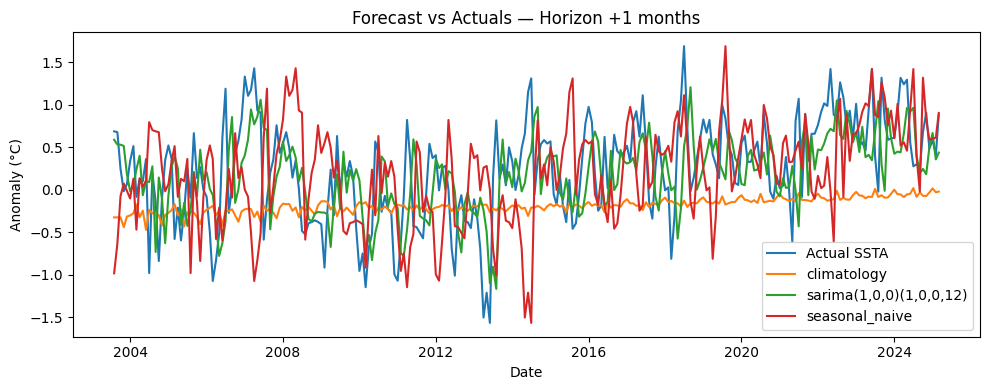

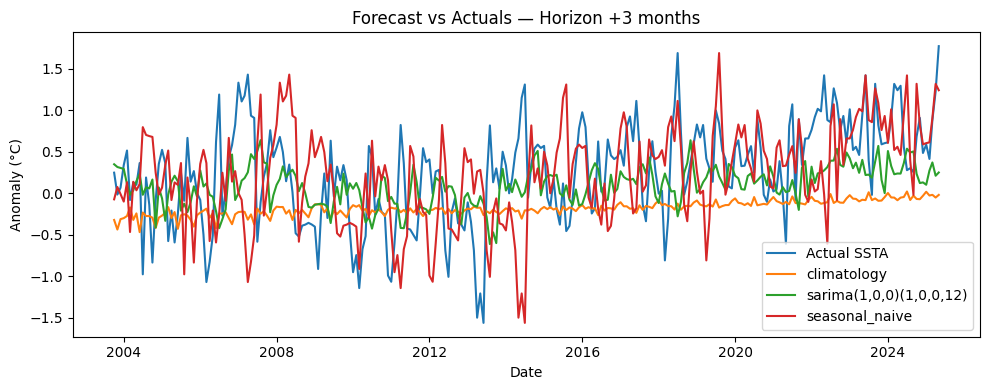

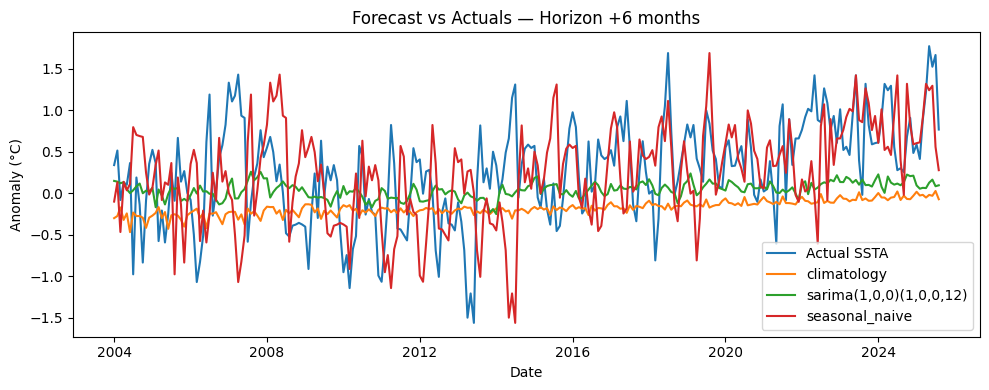

In [9]:

def plot_forecast_vs_actual_for_h(h):
    p = preds[preds["horizon"] == h].copy()
    if p.empty:
        print(f"No predictions for horizon={h}.")
        return
    # One curve per model
    models = sorted(p["model"].unique().tolist())
    actual = p[["date","y_true"]].drop_duplicates().sort_values("date")
    plt.figure(figsize=(10,4))
   
    plt.plot(actual["date"], actual["y_true"], label="Actual SSTA")
    # plot forecasts by model
    for m in models:
        pm = p[p["model"] == m].sort_values("date")
        plt.plot(pm["date"], pm["y_pred"], label=m)
    plt.title(f"Forecast vs Actuals — Horizon +{h} months")
    plt.xlabel("Date"); plt.ylabel("Anomaly (°C)")
    plt.legend()
    plt.tight_layout(); plt.show()

for H in sorted(preds["horizon"].unique()):
    plot_forecast_vs_actual_for_h(int(H))



## 3. Skill vs. climatology

For each horizon, we visualize the relative improvement of each model against the climatology baseline. Positive values indicate better-than-climatology.


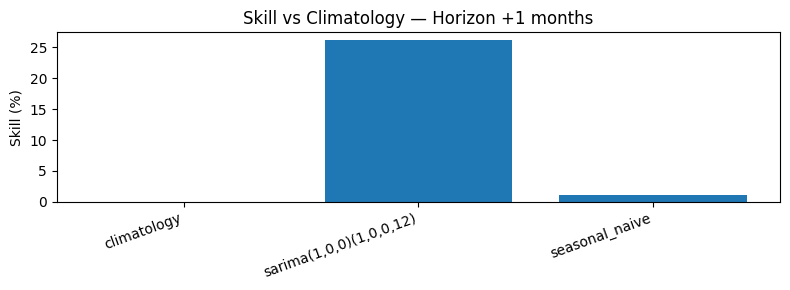

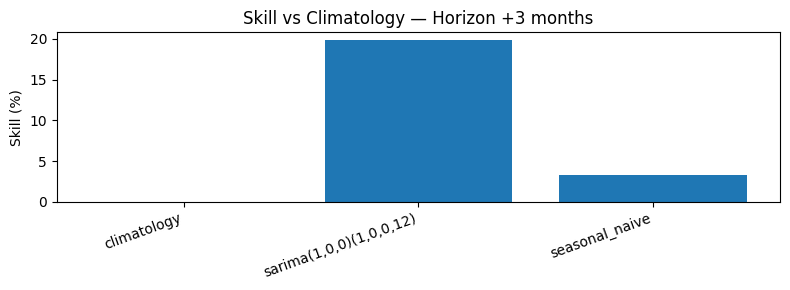

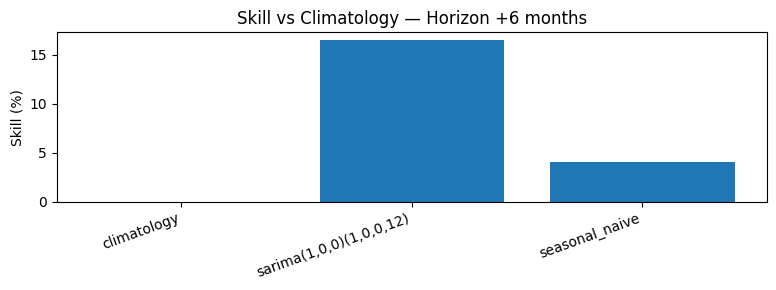

In [10]:

def plot_skill_for_h(h):
    m = metrics[metrics["horizon"] == h].copy()
    if "Skill_vs_Climo_%" not in m.columns:
        print("Skill_vs_Climo_% column not found in metrics. Skipping plot.")
        return
    names = m["model"].tolist()
    vals = m["Skill_vs_Climo_%"].tolist()
    fig = plt.figure(figsize=(8,3))
    plt.bar(range(len(names)), vals)
    plt.xticks(range(len(names)), names, rotation=20, ha="right")
    plt.title(f"Skill vs Climatology — Horizon +{h} months")
    plt.ylabel("Skill (%)")
    plt.tight_layout(); plt.show()

for H in sorted(metrics["horizon"].unique()):
    plot_skill_for_h(int(H))



## 4. Residual diagnostics (best model per horizon)



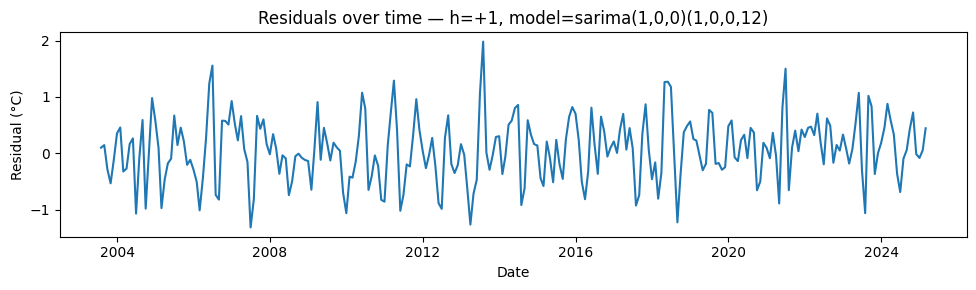

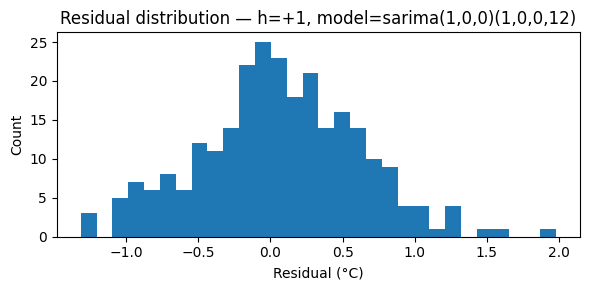

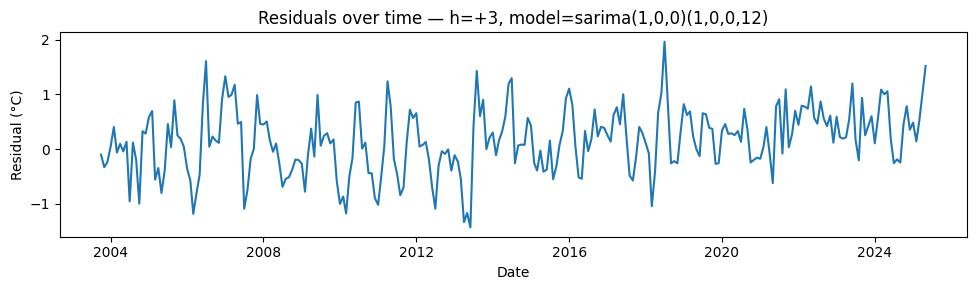

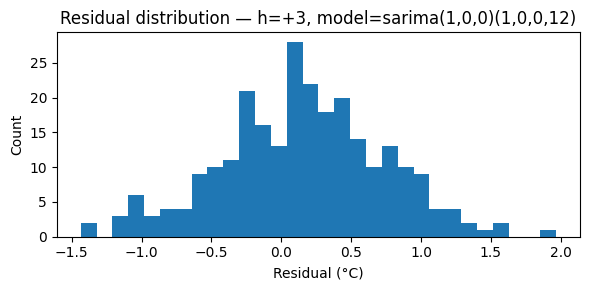

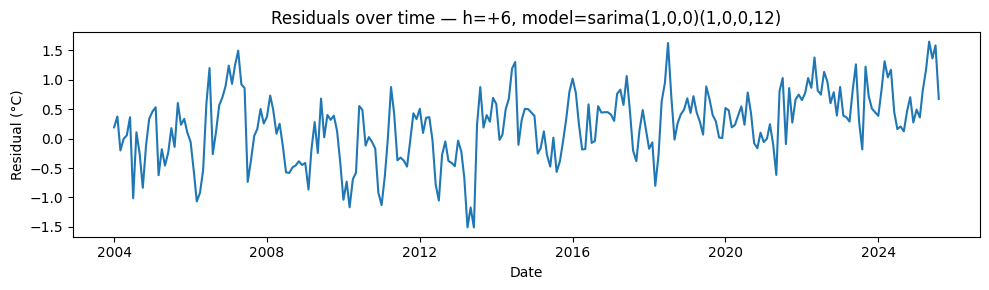

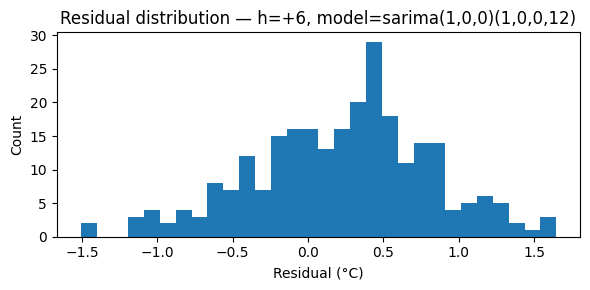

In [ ]:

def plot_residuals_hist_and_ts(h, model_name):
    p = preds[(preds["horizon"] == h) & (preds["model"] == model_name)].copy()
    if p.empty:
        print(f"No data for horizon={h}, model={model_name}")
        return
    p["resid"] = p["y_true"] - p["y_pred"]
    s
    plt.figure(figsize=(10,3))
    plt.plot(p["date"], p["resid"])
    plt.title(f"Residuals over time — h=+{h}, model={model_name}")
    plt.xlabel("Date"); plt.ylabel("Residual (°C)")
    plt.tight_layout(); plt.show()
    # Distribution of residuals
    plt.figure(figsize=(6,3))
    plt.hist(p["resid"].dropna().values, bins=30)
    plt.title(f"Residual distribution — h=+{h}, model={model_name}")
    plt.xlabel("Residual (°C)"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

for _, row in best.iterrows():
    plot_residuals_hist_and_ts(int(row["horizon"]), str(row["model"]))
